In [2]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import os
import shutil
import h5py
import seaborn as sns

In [3]:
ex=['cat.11184.jpg', 'cat.2939.jpg', 'cat.3216.jpg', 'cat.3672.jpg', 'cat.4688.jpg', 'cat.5418.jpg',
     'cat.7377.jpg', 'cat.8470.jpg', 'dog.10747.jpg', 'dog.11299.jpg', 'dog.1194.jpg', 'dog.6725.jpg', 
     'dog.8898.jpg', 'dog.9188.jpg', 'cat.10029.jpg', 'cat.10712.jpg', 'cat.4338.jpg', 'cat.5351.jpg', 
     'cat.7564.jpg', 'cat.7968.jpg', 'cat.8456.jpg', 'cat.9171.jpg', 'dog.10161.jpg', 'dog.10190.jpg', 
     'dog.10237.jpg', 'dog.10801.jpg', 'dog.12376.jpg', 'dog.1259.jpg', 'dog.1773.jpg', 'dog.1895.jpg',
     'dog.2614.jpg', 'dog.4367.jpg', 'dog.5604.jpg', 'dog.6475.jpg', 'dog.8736.jpg', 'dog.9517.jpg']
# ex是需要移除的图片列表

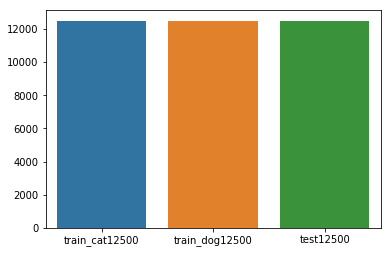

In [25]:
train_filenames = os.listdir('train')
cat =[a for a in train_filenames if 'cat' in a]
dog =[a for a in train_filenames if 'dog' in a]
x = ['train_cat'+str(len(cat)), 'train_dog'+str(len(dog)), 'test'+str(len(os.listdir('test')))]
y = [len(cat), len(dog), len(os.listdir('test'))]
ax = sns.barplot(x=x, y=y)

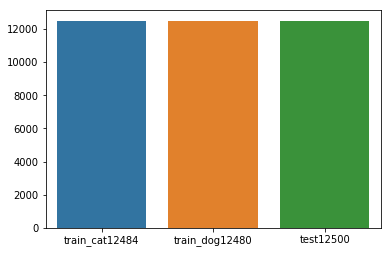

In [24]:
n_cat =[a for a in train_filenames if a not in ex and 'cat' in a]
n_dog =[a for a in train_filenames if a not in ex and 'dog' in a]
x = ['train_cat'+str(len(n_cat)), 'train_dog'+str(len(n_dog)), 'test'+str(len(os.listdir('test')))]
y = [len(n_cat), len(n_dog), len(os.listdir('test'))]
ax = sns.barplot(x=x, y=y)#去除异常图片以后猫狗图片在数据中的数量

In [ ]:
def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('dtrain')
os.mkdir('dtrain/cat')
os.mkdir('dtrain/dog')
rmrf_mkdir('dtest')
os.symlink('../test/', 'dtest/test')

for filename in train_filenames:
    if filename not in ex:# 只有不属于ex中的图片才可生成软连，从而达到排除异常图片的目的
        if 'cat' in filename:
            os.symlink('../../train/'+filename, 'dtrain/cat/'+filename)
        else:
            os.symlink('../../train/'+filename, 'dtrain/dog/'+filename)
    

In [2]:
def get_gap(MODEL,lambda_func=None):

    input_tensor = Input((299, 299, 3))
    x = input_tensor
    x = Lambda(lambda_func)(x)
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    idg = ImageDataGenerator()
    train_generator = idg.flow_from_directory("dtrain", (299, 299), shuffle=False, batch_size=16)
    test_generator = idg.flow_from_directory("dtest", (299, 299), shuffle=False, batch_size=16, class_mode=None)
    
    train = model.predict_generator(train_generator)
    test = model.predict_generator(test_generator)
    
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [5]:
get_gap(InceptionV3, inception_v3.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [4]:
get_gap(Xception, xception.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [3]:
get_gap(InceptionResNetV2,inception_resnet_v2.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
